In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

plt.style.use('ggplot')

In [34]:
# timeIndex
ti = pd.date_range(start='2020-01-01', end='2020-07-31')

In [65]:
# Let's Create a Linear Function that determinates the relationship between or y and X variables
def response_linearfunc(x, a, b):
    return a*x + b

In [66]:
# Predictor Variable X - We're going to Use a random variable, normally distributed
xdata = np.random.randn(len(ti)) + 5

# Response Variable y - Linear Combination of X + random noise
y_raw = response_linearfunc(xdata, 2, 1)
y_noise = (0.1 * np.random.normal(size=xdata.size) * y_raw)
ydata = y_raw + y_noise

In [67]:
### Building a DataFrame
df = pd.DataFrame(data={'y': ydata, 
                        'X': xdata}, 
                  index=ti)

In [68]:
df.head()

,y,X
2020-01-01,5.120947,3.022925
2020-01-02,12.087966,5.077254
2020-01-03,10.876662,4.637643
2020-01-04,12.473197,5.534200
2020-01-05,11.430620,5.620926


In [69]:
# Header of the Result DataFrame
df.head()

,y,X
2020-01-01,5.120947,3.022925
2020-01-02,12.087966,5.077254
2020-01-03,10.876662,4.637643
2020-01-04,12.473197,5.534200
2020-01-05,11.430620,5.620926


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213 entries, 2020-01-01 to 2020-07-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       213 non-null    float64
 1   X       213 non-null    float64
dtypes: float64(2)
memory usage: 13.1 KB


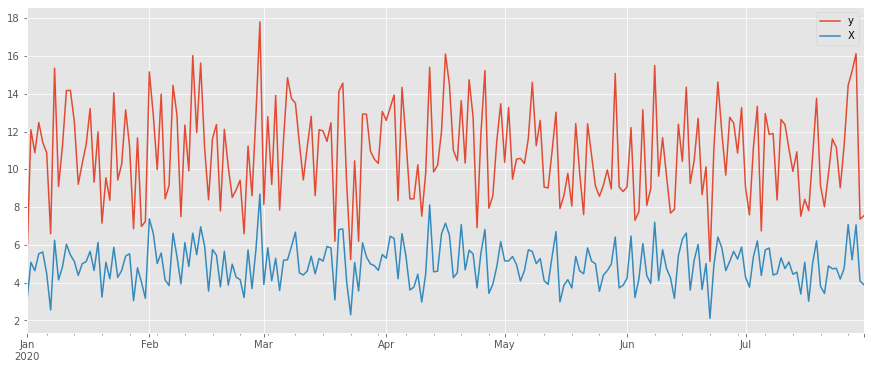

In [71]:
# Plotting the Series
df.plot(figsize=(15,6));

In [72]:
# Creating Linear Trend
linear_trend = response_linearfunc(np.linspace(0,5,len(ti)), 3, 1)

In [73]:
df['linearTrend'] = linear_trend

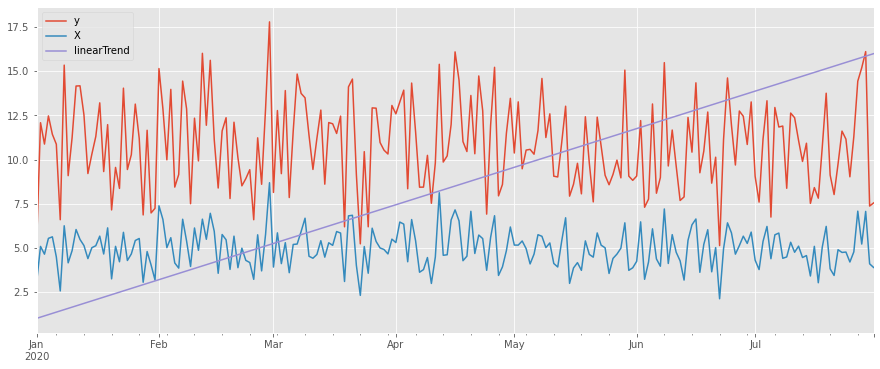

In [74]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [75]:
df['y'] = df['y'] + df['linearTrend']

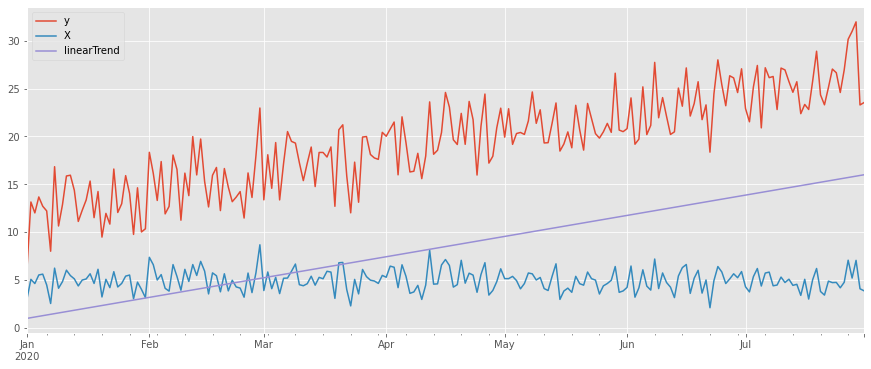

In [76]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [77]:
# Syntethic Seasonal Data
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,
                           harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:] # Discard burn in

    return wanted_series

In [78]:
duration = len(ti)
periodicities = [30]
num_harmonics = [1]
std = np.array([0.1, 0.1])

In [79]:
terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
seasons = pd.Series(np.sum(terms, axis=0))

In [80]:
df['seasonalTrend'] = (seasons.values / 5) - 3

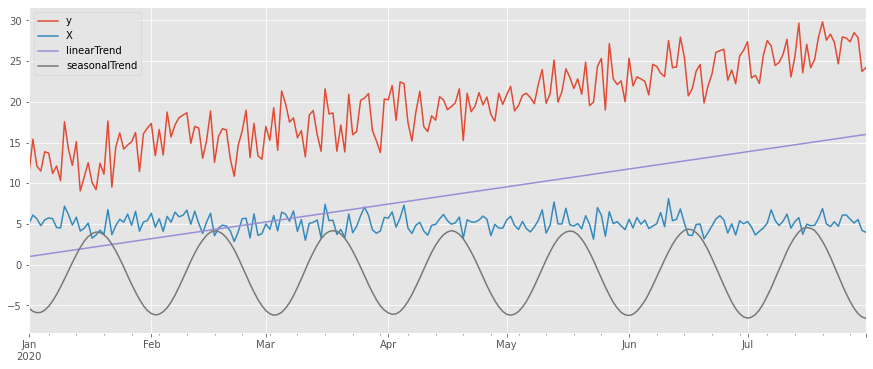

In [51]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [52]:
df['y'] = df['y'] + df['seasonalTrend']

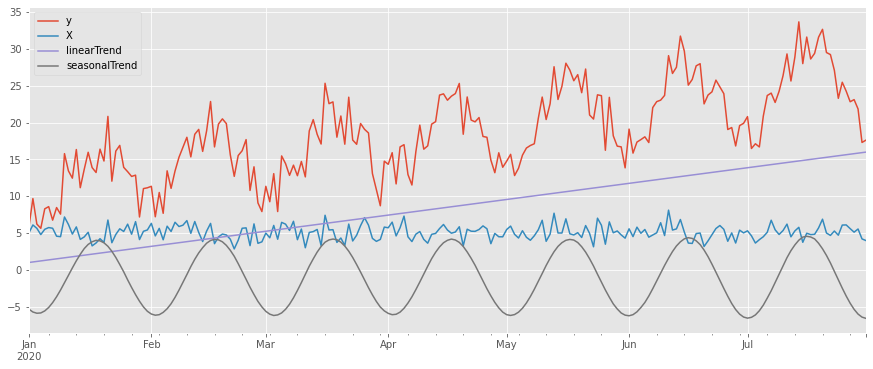

In [53]:
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [54]:
# Introducing Incremental Effect at last 30 days by 5 units
df['y'].loc['2020-07-01':] = df['y'].loc['2020-07-01':] + 5

In [55]:
df.drop(['linearTrend', 'seasonalTrend'], axis=1, inplace=True)

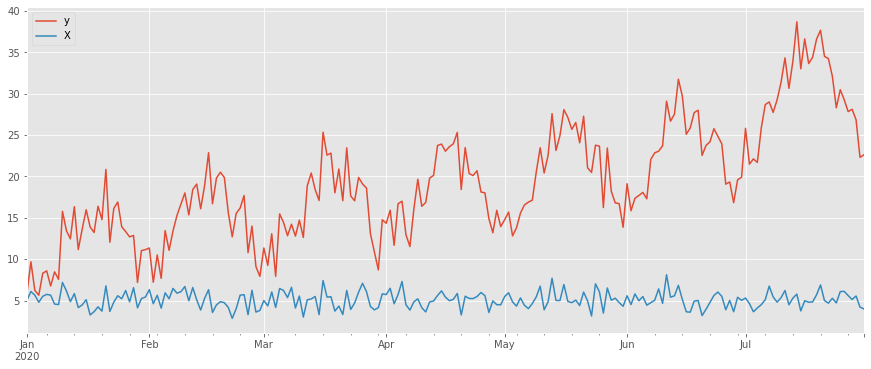

In [56]:
# Checking the Result of Incremental Effect
df.plot(figsize=(15,6));

In [57]:
pre_period = ["2020-01-01","2020-06-30"]
post_period = ["2020-07-01","2020-07-31"]

In [58]:
ciModel = CausalImpact(df, pre_period, post_period)

/home/ronggolawe/anaconda3/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


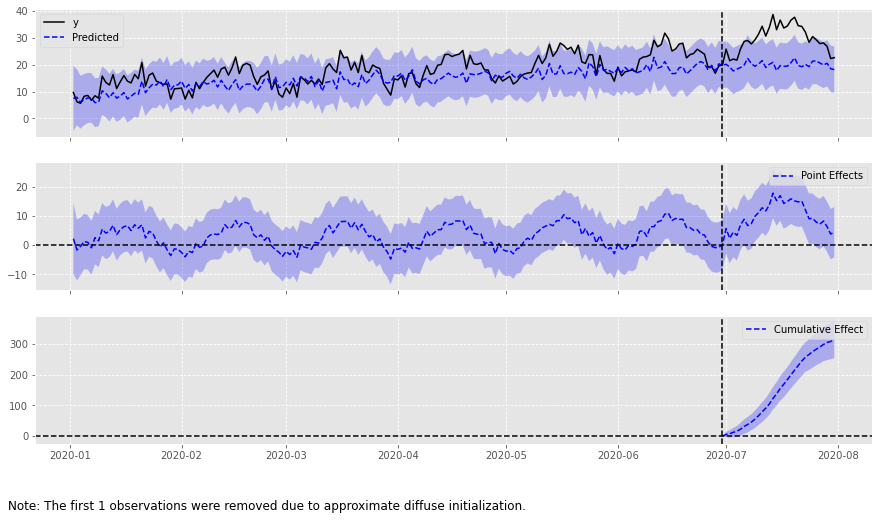

In [59]:
# Model Results Plot
ciModel.plot(figsize=(15,8));

In [60]:
# Model Results - Simple 
print(ciModel.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    29.99              929.6
Prediction (s.d.)         19.9 (0.98)        617.02 (30.46)
95% CI                    [17.96, 21.81]     [556.7, 676.08]

Absolute effect (s.d.)    10.08 (0.98)       312.58 (30.46)
95% CI                    [8.18, 12.03]      [253.51, 372.9]

Relative effect (s.d.)    50.66% (4.94%)     50.66% (4.94%)
95% CI                    [41.09%, 60.44%]   [41.09%, 60.44%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [61]:
ciModel = CausalImpact(df, pre_period, post_period, nseasons=[{'period': 30}])

/home/ronggolawe/anaconda3/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


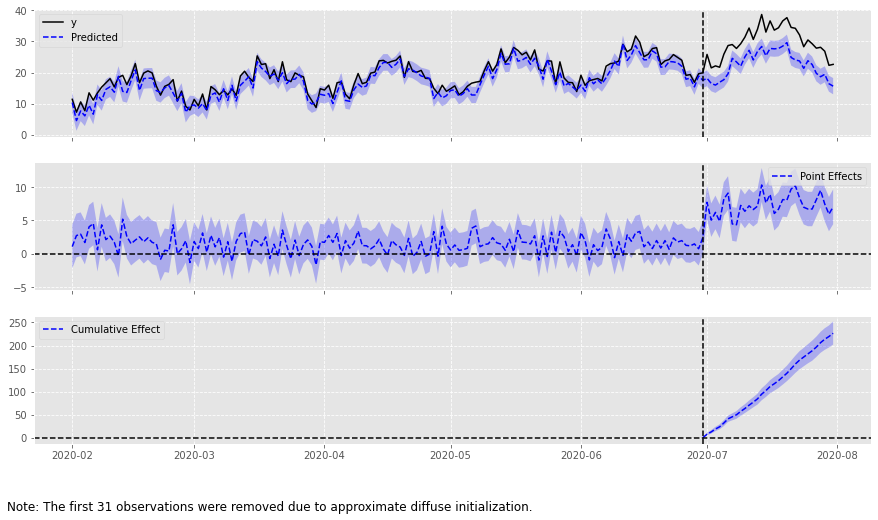

In [62]:
# Model Results Plot
ciModel.plot(figsize=(15,8));

In [63]:
print(ciModel.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    29.99              929.6
Prediction (s.d.)         22.68 (0.41)       702.96 (12.76)
95% CI                    [21.85, 23.46]     [677.37, 727.39]

Absolute effect (s.d.)    7.31 (0.41)        226.63 (12.76)
95% CI                    [6.52, 8.14]       [202.2, 252.23]

Relative effect (s.d.)    32.24% (1.82%)     32.24% (1.82%)
95% CI                    [28.76%, 35.88%]   [28.76%, 35.88%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [81]:
print(ciModel.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 29.99. By contrast, in the absence of an
intervention, we would have expected an average response of 22.68.
The 95% interval of this counterfactual prediction is [21.85, 23.46].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 7.31 with a 95% interval of
[6.52, 8.14]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 929.6.
By contrast, had the intervention not taken place, we would have expected
a sum of 702.96. The 95% interval of this prediction is [677.37, 727.39].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s